In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from PIL import Image

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Sequential
from keras.layers import LSTM, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Activation, Dropout, Input, Embedding, Masking
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# System libraries
import os
import pathlib
from tqdm import tqdm
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

tf.__version__, keras.__version__

('2.11.0', '2.11.0')

In [ ]:
# 데이터 프레임 만들기

data = pd.DataFrame(columns = ['Img', 'isFire'])


# 이미지 이진 분류 파일 설정( 화재, 화재 X)
non_folders = ['/content/drive/MyDrive/동엽/data/fire_dataset/non_fire_images','/content/drive/MyDrive/동엽/data/Fire-Detection/0']
folders = ['/content/drive/MyDrive/동엽/data/Datacluster Fire and Smoke Sample','/content/drive/MyDrive/동엽/data/fire_dataset/fire_images', '/content/drive/MyDrive/동엽/data/Fire-Detection/1']

# 화재가 아닌 데이터
for folder in non_folders:
  for dirname, dir_, filenames in os.walk(folder):
    for file in filenames:
        data = data.append(pd.DataFrame([[os.path.join(dirname, file), 0]], columns = ['Img', 'isFire']))

# 화재인 데이터
for folder in folders:
  for dirname, dir_, filenames in os.walk(folder):
    for file in filenames:
        data = data.append(pd.DataFrame([[os.path.join(dirname, file), 1]], columns = ['Img', 'isFire']))

# 인덱스 초기화
data = data.reset_index(drop = True)
data

,Img,isFire
0,/content/drive/MyDrive/동엽/data/fire_datase...,0
1,/content/drive/MyDrive/동엽/data/fire_datase...,0
2,/content/drive/MyDrive/동엽/data/fire_datase...,0
3,/content/drive/MyDrive/동엽/data/fire_datase...,0
4,/content/drive/MyDrive/동엽/data/fire_datase...,0
...,...,...
1745,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1746,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1747,/content/drive/MyDrive/동엽/data/Fire-Detect...,1
1748,/content/drive/MyDrive/동엽/data/Fire-Detect...,1


In [ ]:
import cv2

# 크기 조절, 스케일링, 이미지 -> 배열 전환
def GiveImages(data):
    image_array = [] 
    class_name = []
    non_image = []
    IMG_SIZE = 256 # 표준 이미지 사이즈 ( 256 * 256 ) 설정
    
    for i in tqdm(range(data.shape[0])):
        image = cv2.imread(data.Img[i], cv2.COLOR_BGR2RGB) # BGR -> RGB 형태 변환
        try:
          image = cv2.resize(image, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC) # 정사각형 이미지로 설정
        except:
          non_image = i # 이미지 상 오류 발생하는 경우 있음
          continue
        image = np.array(image) # 이미지를 배열 전환
        image = image.astype('float32') # 데이터 타입 변환
        image /= 255 # 사이즈 조절
        
        image_array.append(image)
        class_name.append(data['isFire'][i])

    return np.array(image_array), np.array(class_name), non_image

X, y, non_img = GiveImages(data)
#Show the shape of X and Y
X.shape, y.shape, non_img

100%|██████████| 1750/1750 [06:46<00:00,  4.30it/s]


((1749, 256, 256, 3), (1749,), 131)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1399, 256, 256, 3), (350, 256, 256, 3), (1399,), (350,))

In [ ]:
print('NON-FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==0].shape[0])
print('FIRE IMAGES ON TRAINING DATA: ',y_train[y_train==1].shape[0])

NON-FIRE IMAGES ON TRAINING DATA:  617
FIRE IMAGES ON TRAINING DATA:  782


In [ ]:
# 학습 변수 설정
EPOCH = 30 # 설정 : 학습
BATCH_SIZE = 128 # 설정 : 1회 학습 시 128개 데이터 사용
IS_GPU = True

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
'''
  include_top = True : 불러온 신경망의 가장 마지막층(출력층)을 포함시킨다 , False 시 빼고 가져온다
  weights = 'imagenet' : imagenet -> 이미지넷으로부터 사전학습된 모델, 가중치를 그대로 사용
  input_shape = None : 원래 모델의 크기와 다른 이미지를 사용 할 것이므로 -> 새로 학습 -> 전체데이터 -> shape 변경 

'''
vgg16 = VGG16(include_top = False, weights = 'imagenet', input_shape = (256,256,3))
vgg16_input = vgg16.input
vgg16.tranable = False

x = Flatten()(vgg16.output)
x = Dense(64, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation = 'relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation = 'relu')(x)
x = Dropout(0.1)(x)
vgg16_output = Dense(1, activation = 'sigmoid')(x)
vgg16_model = Model(inputs = vgg16_input, outputs = vgg16_output)
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [ ]:
vgg16_model.compile(
    optimizer = optimizers.Adam(learning_rate = 0.0001), # 최적화 도구 
    loss = 'binary_crossentropy', # 손실함수 : 값이 0에 가까울 수록 좋다 
    metrics = ['accuracy']
)

In [ ]:
vgg16_callbacks = [
  # 조기학습 종료가 되고, patiemce 회수만큼 더 학습을 수행하는데 변동이 없다면 종료
  EarlyStopping(
    monitor = "val_loss",
    patience = 10,
    restore_best_weights = True
  ),
  # 모델 저장, 옵션따라 조건이 달라짐. 기본값 기준 세대별 저장
  ModelCheckpoint(
    filepath='/content/drive/MyDrive/동엽/model_save/vgg16_model_{epoch:02d}-{val_loss:.2f}.h5',
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
  ),
  # 텐서보드 로드용 데이터 저장
  TensorBoard(log_dir='./logs'),

  # Learning Rate를 조절해 모델의 개선을 유도 :  https://deep-deep-deep.tistory.com/56
  ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5),
]

In [ ]:
vgg16_hist = vgg16_model.fit(
      X_train, 
      y_train,
      batch_size = BATCH_SIZE,
      epochs = EPOCH,
      validation_data = (X_test, y_test), # 편의상 검증용 제너레이터가 없어서 테스트용 사용 -> 과적합 방지
      callbacks = vgg16_callbacks
  )

Epoch 1/30
11/11 [==============================] - 38s 3s/step - loss: 0.6678 - accuracy: 0.5990 - val_loss: 0.6641 - val_accuracy: 0.5429 - lr: 1.0000e-04
Epoch 2/30
11/11 [==============================] - 31s 3s/step - loss: 0.5215 - accuracy: 0.7441 - val_loss: 0.3129 - val_accuracy: 0.8571 - lr: 1.0000e-04
Epoch 3/30
11/11 [==============================] - 31s 3s/step - loss: 0.3739 - accuracy: 0.8377 - val_loss: 0.3296 - val_accuracy: 0.8886 - lr: 1.0000e-04
Epoch 4/30
11/11 [==============================] - 32s 3s/step - loss: 0.2941 - accuracy: 0.8828 - val_loss: 0.3075 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/30
11/11 [==============================] - 31s 3s/step - loss: 0.2748 - accuracy: 0.8935 - val_loss: 0.1415 - val_accuracy: 0.9429 - lr: 1.0000e-04
Epoch 6/30
11/11 [==============================] - 32s 3s/step - loss: 0.2011 - accuracy: 0.9321 - val_loss: 0.1180 - val_accuracy: 0.9600 - lr: 1.0000e-04
Epoch 7/30
11/11 [==============================] - 32s 3s

In [ ]:
# 모델 정보 시각화
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
vgg16_model.evaluate(X_test, y_test)

11/11 [==============================] - 7s 422ms/step - loss: 0.0970 - accuracy: 0.9657


[0.09703560173511505, 0.9657142758369446]

In [ ]:
history = vgg16_hist.history

In [ ]:
import plotly.express as px
px.line(history,title = "Metrics Plot")

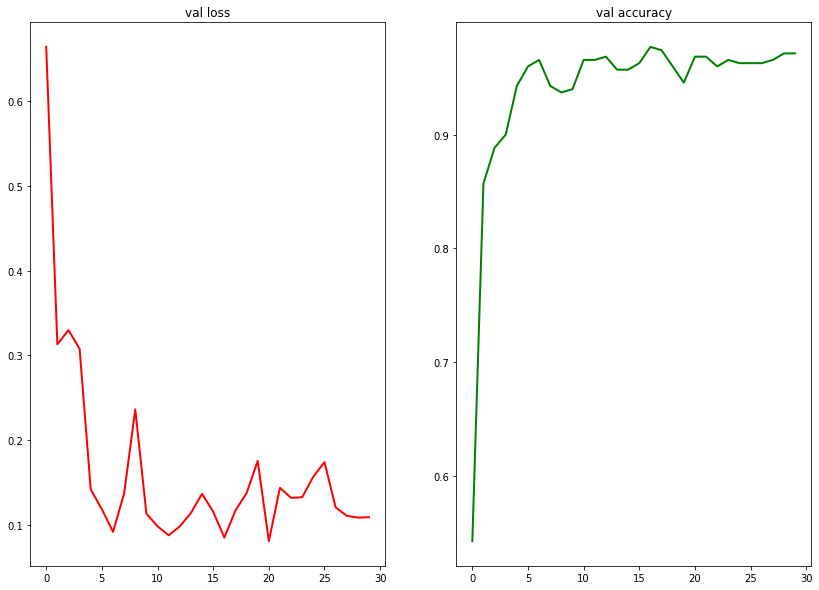

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(14,10))
axes[0].set_title('val loss');
axes[1].set_title('val accuracy')

axes[0].plot(history['val_loss'], color = 'red', lw=2);
axes[1].plot(history['val_accuracy'], color = 'green', lw=2);

11/11 [==============================] - 2s 160ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       167
           1       0.97      0.98      0.97       183

    accuracy                           0.97       350
   macro avg       0.97      0.97      0.97       350
weighted avg       0.97      0.97      0.97       350



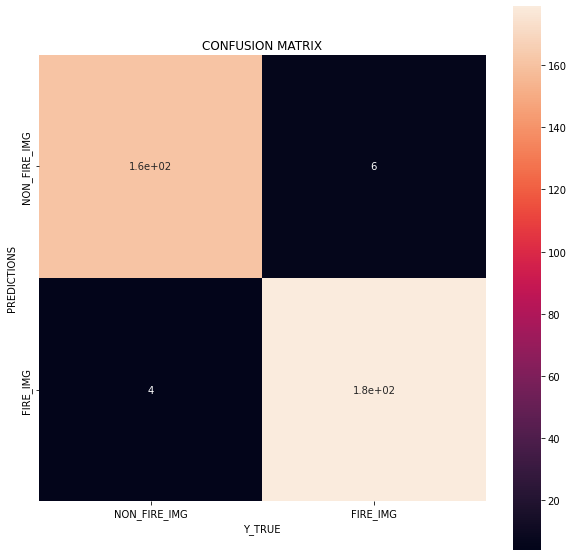

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

y_pred = (vgg16_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

confusion_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat, 
            square=True, 
            annot=True,
            yticklabels=['NON_FIRE_IMG', 'FIRE_IMG'],
            xticklabels=['NON_FIRE_IMG', 'FIRE_IMG']);
plt.title('CONFUSION MATRIX');
plt.xlabel('Y_TRUE');
plt.ylabel("PREDICTIONS");

In [ ]:
# 예측 할 데이터 셋 불러오기

pred_data = pd.DataFrame(columns = ['Img', 'isFire'])


# 화재가 아닌 데이터
for dirname, dir_, filenames in os.walk("/content/drive/MyDrive/동엽/data/predict"):
  for file in filenames:
      pred_data = pred_data.append(pd.DataFrame([[os.path.join(dirname, file), 0]], columns = ['Img', 'isFire']))

# 인덱스 초기화
pred_data = pred_data.reset_index(drop = True)
pred_data

,Img,isFire
0,/content/drive/MyDrive/동엽/data/predict/150...,0
1,/content/drive/MyDrive/동엽/data/predict/152...,0
2,/content/drive/MyDrive/동엽/data/predict/156...,0
3,/content/drive/MyDrive/동엽/data/predict/160...,0
4,/content/drive/MyDrive/동엽/data/predict/150...,0
5,/content/drive/MyDrive/동엽/data/predict/228...,0
6,/content/drive/MyDrive/동엽/data/predict/506...,0
7,/content/drive/MyDrive/동엽/data/predict/508...,0
8,/content/drive/MyDrive/동엽/data/predict/529...,0
9,/content/drive/MyDrive/동엽/data/predict/116...,0


In [ ]:
# 전처리 
x_pred, y_pred, non_img = GiveImages(pred_data)
x_pred, y_pred, non_img

100%|██████████| 20/20 [00:00<00:00, 51.26it/s]


(array([[[[0.        , 0.        , 0.        ],
          [0.00392157, 0.00784314, 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.00392157, 0.00392157, 0.00392157],
          [0.00392157, 0.00392157, 0.04313726],
          [0.00784314, 0.00392157, 0.01568628],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.00392157, 0.        , 0.00392157],
          [0.        , 0.00392157, 0.        ],
          [0.        , 0.00392157, 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.00784314, 0.00784314, 0.23137255],
          [0.01176

In [ ]:
pred = vgg16_model.predict(x_pred)
pred

1/1 [==============================] - 0s 36ms/step


array([[9.9999976e-01],
       [1.0000000e+00],
       [2.5776633e-06],
       [9.9969339e-01],
       [1.0000000e+00],
       [9.9987507e-01],
       [9.9491298e-01],
       [1.1265611e-03],
       [1.4440159e-05],
       [1.2794018e-03],
       [9.9442968e-07],
       [9.8564756e-01],
       [1.9893971e-06],
       [9.9999309e-01],
       [5.8139779e-08],
       [8.6823952e-01],
       [6.1388429e-11],
       [3.4627569e-04],
       [9.4235816e-08],
       [9.9203604e-01]], dtype=float32)

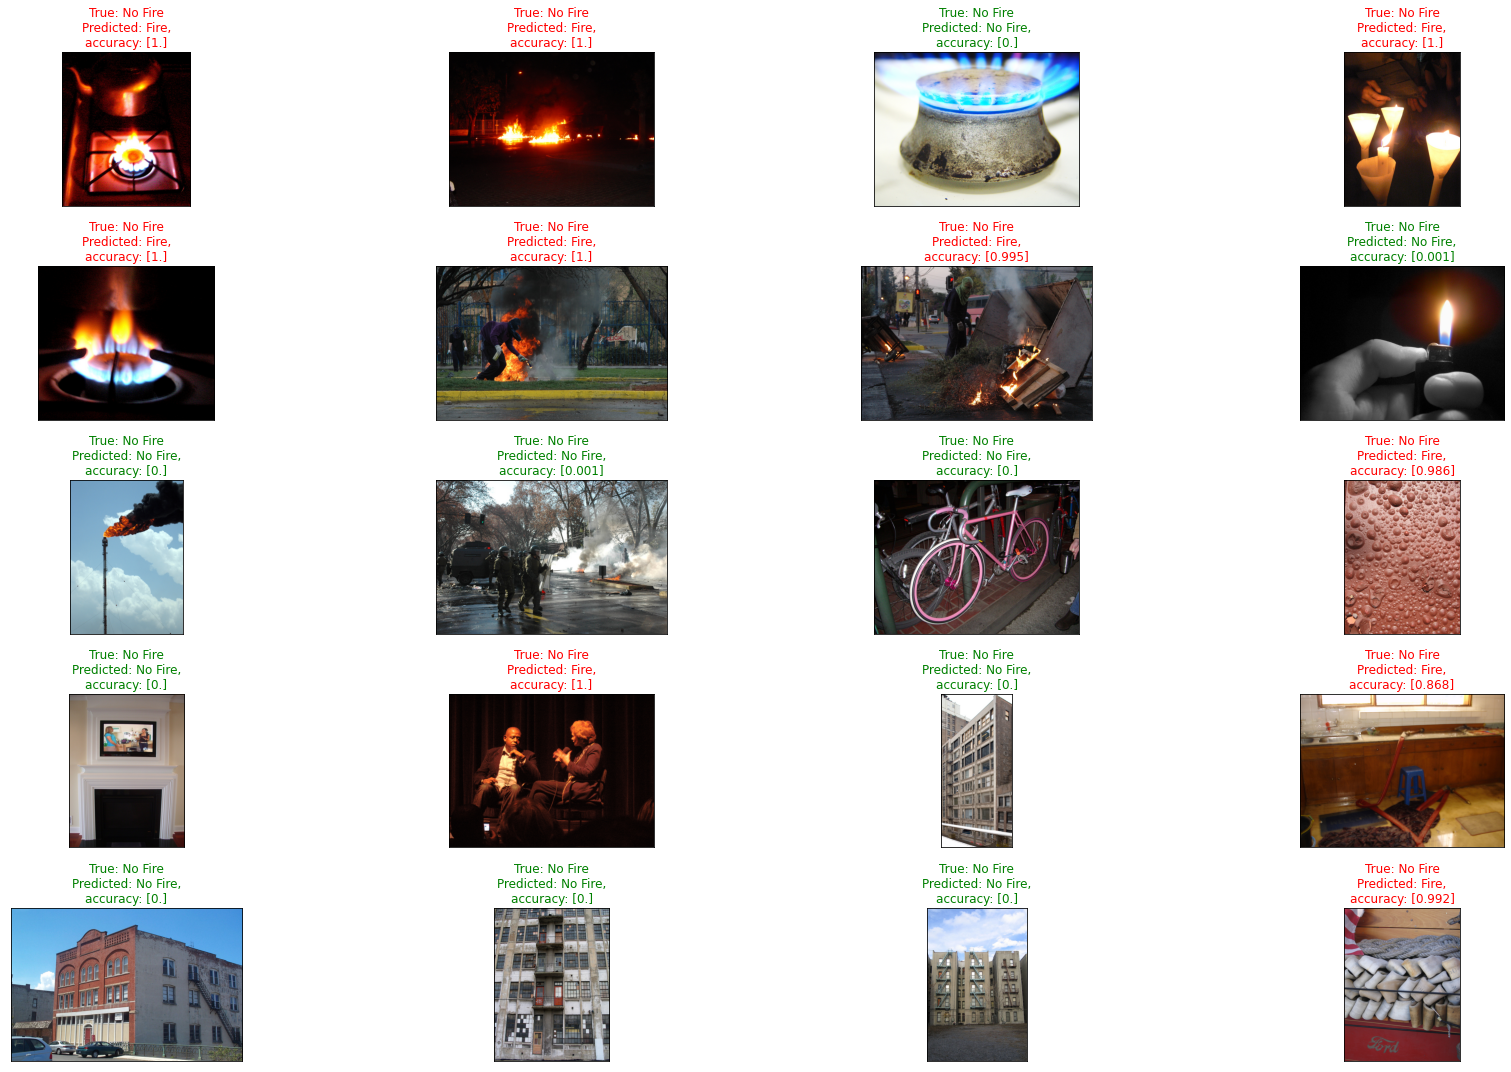

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    pred_img = Image.open(pred_data.Img.iloc[i])
    true_label = "Fire" if pred_data.isFire.iloc[i] else "No Fire"
    pred_label = "Fire" if pred[i] > 0.5 else "No Fire"  # 이진 분류를 위한 수정
    ax.imshow(pred_img)
    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label},\naccuracy: {np.round(pred[i],3)}", color=color)
plt.tight_layout()
plt.show()

# 베이스라인과 달리 정확도가 높은 경우가 있지만, 편차가 매우 큰 편이다